In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import copy
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define a consistent BATCH_SIZE
BATCH_SIZE = 64

Using device: cuda


In [4]:
#clear directory
!cd /kaggle/working/
!rm -rf *

In [5]:
import shutil
import os

# Path to your Kaggle input dataset
input_path = "/kaggle/input/realwaste-dataset/realwaste-main/RealWaste"

# Path to your working directory
working_path = "/kaggle/working/realwaste"

# Copy the entire folder
shutil.copytree(input_path, working_path, dirs_exist_ok=True)

print("✅ Dataset copied successfully to working directory!")


✅ Dataset copied successfully to working directory!


In [8]:
import os
import shutil
import random

# Source dataset path
source_dir = "/kaggle/working/realwaste"

# Destination base directory (in working directory)
base_output = "/kaggle/working/realwaste_split"

# Split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Create output directories
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(base_output, split), exist_ok=True)

# Iterate through each class folder
for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    if not os.path.isdir(class_path):
        continue  # skip non-folder items

    # List all image files in class folder
    images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    random.shuffle(images)

    # Compute split indices
    total = len(images)
    train_end = int(train_ratio * total)
    val_end = int((train_ratio + val_ratio) * total)

    # Split images
    train_files = images[:train_end]
    val_files = images[train_end:val_end]
    test_files = images[val_end:]

    # Copy images into respective folders
    for split, file_list in zip(['train', 'val', 'test'], [train_files, val_files, test_files]):
        split_dir = os.path.join(base_output, split, class_name)
        os.makedirs(split_dir, exist_ok=True)

        for fname in file_list:
            src = os.path.join(class_path, fname)
            dst = os.path.join(split_dir, fname)
            shutil.copy2(src, dst)

    print(f"✅ {class_name}: {len(train_files)} train, {len(val_files)} val, {len(test_files)} test")

print("\n🎯 Dataset successfully split into train, val, and test folders!")


✅ Textile Trash: 222 train, 48 val, 48 test
✅ Miscellaneous Trash: 346 train, 74 val, 75 test
✅ Glass: 294 train, 63 val, 63 test
✅ Paper: 350 train, 75 val, 75 test
✅ Food Organics: 287 train, 62 val, 62 test
✅ Vegetation: 305 train, 65 val, 66 test
✅ Plastic: 644 train, 138 val, 139 test
✅ Cardboard: 322 train, 69 val, 70 test
✅ Metal: 553 train, 118 val, 119 test

🎯 Dataset successfully split into train, val, and test folders!


In [11]:
# --- Kaggle Data Path Configuration ---

BASE_DATA_PATH = "/kaggle/working/realwaste_split" 
# Verify the paths are correct for your specific Kaggle setup.
train_dir = os.path.join(BASE_DATA_PATH, "train")
val_dir = os.path.join(BASE_DATA_PATH, "val")
test_dir = os.path.join(BASE_DATA_PATH, "test")

# Define standard normalization parameters (e.g., ImageNet mean/std)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Removed all data augmentation for the training set as requested
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # Use Resize instead of RandomResizedCrop
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD) 
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Create ImageFolder datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset   = datasets.ImageFolder(val_dir, transform=val_test_transforms)
test_dataset  = datasets.ImageFolder(test_dir, transform=val_test_transforms)

num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")

Number of classes: 9


In [12]:
# Calculate class weights for WeightedRandomSampler (for imbalanced data handling)
class_counts = np.bincount(train_dataset.targets)
print("Class counts:", class_counts)

# Compute class weights (inverse of frequency)
class_weights_tensor = 1. / torch.tensor(class_counts, dtype=torch.float)

# Ensure sample_weights are floats for the sampler
sample_weights = [class_weights_tensor[label].item() for label in train_dataset.targets]

print("\n📊 Class counts per category:")
for cls, count in zip(train_dataset.classes, class_counts):
    print(f"  {cls:15s}: {count}")

print("\n⚖️ Class weights (inverse of frequency):")
for cls, w in zip(train_dataset.classes, class_weights_tensor):
    print(f"  {cls:15s}: {w:.6f}")

# Create the WeightedRandomSampler
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# Create DataLoaders
# Set num_workers based on your Kaggle environment's resources (usually 2 or 4 is safe)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


print("\n✅ DataLoaders and WeightedRandomSampler created successfully!")
print(f"➡️ Total samples in epoch: {len(sample_weights)}")
print(f"➡️ Training Batch size: {train_loader.batch_size}")
print(f"➡️ Validation Batch size: {val_loader.batch_size}")
print(f"➡️ Total training batches per epoch: {len(train_loader)}")

Class counts: [427 373 381 717 451 459 832 287 399]

📊 Class counts per category:
  Cardboard      : 427
  Food Organics  : 373
  Glass          : 381
  Metal          : 717
  Miscellaneous Trash: 451
  Paper          : 459
  Plastic        : 832
  Textile Trash  : 287
  Vegetation     : 399

⚖️ Class weights (inverse of frequency):
  Cardboard      : 0.002342
  Food Organics  : 0.002681
  Glass          : 0.002625
  Metal          : 0.001395
  Miscellaneous Trash: 0.002217
  Paper          : 0.002179
  Plastic        : 0.001202
  Textile Trash  : 0.003484
  Vegetation     : 0.002506

✅ DataLoaders and WeightedRandomSampler created successfully!
➡️ Total samples in epoch: 4326
➡️ Training Batch size: 64
➡️ Validation Batch size: 64
➡️ Total training batches per epoch: 68


In [13]:
# Define the custom CNN model (WasteCNN)
class WasteCNN(nn.Module):
    def __init__(self, num_classes=9):
        super(WasteCNN, self).__init__()
        # Convolutional Layers with Batch Normalization and Max Pooling
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Dynamically determine the size of the feature maps after convolutional layers
        self._to_linear = None
        self.calculate_flatten_size(224) # Assuming an input image size of 224x224

        # Fully Connected Layers
        self.fc1 = nn.Linear(self._to_linear, 256)
        self.dropout = nn.Dropout(0.5) # Dropout for regularization
        self.fc2 = nn.Linear(256, num_classes) # Output layer

    def calculate_flatten_size(self, input_size):
        # Pass a dummy tensor through the convolutional layers to determine the flattened size
        with torch.no_grad():
            x = torch.zeros(1, 3, input_size, input_size)
            x = self.pool(F.relu(self.bn1(self.conv1(x))))
            x = self.pool(F.relu(self.bn2(self.conv2(x))))
            x = self.pool(F.relu(self.bn3(self.conv3(x))))
            self._to_linear = x.view(x.size(0), -1).size(1)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        x = x.view(-1, self._to_linear) # Flatten the output
        x = self.dropout(F.relu(self.fc1(x))) # Apply dropout and ReLU to the first FC layer
        x = self.fc2(x) # Output layer (logits)
        return x

print("WasteCNN model class defined and ready for use.")

WasteCNN model class defined and ready for use.


In [14]:
# Function to get a new model instance, optionally with identical initial weights
# For a fair comparison, all models should ideally start from the same initial random weights.
def get_fresh_model_for_comparison(num_classes, device, base_model_path='initial_model_weights.pth'):
    if not os.path.exists(base_model_path):
        # If no base model state exists, create one and save its initial state
        initial_model = WasteCNN(num_classes=num_classes).to(device)
        torch.save(initial_model.state_dict(), base_model_path)
        print(f"Created and saved initial model weights to {base_model_path}")
        return initial_model
    else:
        # Load the saved initial state into a new model instance
        new_model = WasteCNN(num_classes=num_classes).to(device)
        new_model.load_state_dict(torch.load(base_model_path))
        return new_model

# --- Define a generic Training Function for Optimizer Comparison ---\n
def run_optimizer_training_comparison(model_instance, optimizer_name, optimizer_obj, criterion_obj, scheduler_obj, num_epochs_comp, train_loader_comp, val_loader_comp, device_comp):
    print(f"\nTraining with {optimizer_name} for {num_epochs_comp} epochs...")

    current_train_losses = []
    current_train_accuracies = []
    current_val_losses = []
    current_val_accuracies = []

    best_val_acc_run = 0.0
    model_path_run = f'best_model_comparison_{optimizer_name.lower().replace(" ", "_").replace("-", "_")}.pth'

    for epoch in range(num_epochs_comp):
        # Training phase
        model_instance.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0

        train_loop = tqdm(train_loader_comp, desc=f"Epoch {epoch+1}/{num_epochs_comp} ({optimizer_name} Train)", leave=False)
        for images, labels in train_loop:
            images, labels = images.to(device_comp), labels.to(device_comp)

            optimizer_obj.zero_grad() # Zero the parameter gradients
            outputs = model_instance(images) # Forward pass
            loss = criterion_obj(outputs, labels) # Calculate loss
            loss.backward() # Backward pass
            optimizer_obj.step() # Optimize

            running_loss += loss.item() * images.size(0) # Aggregate loss

            _, predicted = torch.max(outputs, 1) # Get predictions
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            train_loop.set_postfix(loss=loss.item())

        epoch_train_loss = running_loss / len(train_loader_comp.dataset)
        epoch_train_accuracy = 100 * train_correct / train_total
        current_train_losses.append(epoch_train_loss)
        current_train_accuracies.append(epoch_train_accuracy)

        if scheduler_obj:
            scheduler_obj.step() # Update learning rate if a scheduler is provided

        # Validation phase
        model_instance.eval() # Set model to evaluation mode
        val_correct = 0
        val_total = 0
        val_running_loss = 0.0

        with torch.no_grad(): # Disable gradient computation
            val_loop = tqdm(val_loader_comp, desc=f"Epoch {epoch+1}/{num_epochs_comp} ({optimizer_name} Val)", leave=False)
            for images, labels in val_loop:
                images, labels = images.to(device_comp), labels.to(device_comp)
                outputs = model_instance(images)
                loss = criterion_obj(outputs, labels)
                val_running_loss += loss.item() * images.size(0)

                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        epoch_val_loss = val_running_loss / len(val_loader_comp.dataset)
        epoch_val_accuracy = 100 * val_correct / val_total
        current_val_losses.append(epoch_val_loss)
        current_val_accuracies.append(epoch_val_accuracy)

        print(f"  {optimizer_name} - Epoch [{epoch+1}/{num_epochs_comp}] "
              f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_accuracy:.2f}% | "
              f"Val Loss: {epoch_val_loss:.4f} | Val Accuracy: {epoch_val_accuracy:.2f}%")

        if epoch_val_accuracy > best_val_acc_run:
            best_val_acc_run = epoch_val_accuracy
            torch.save(model_instance.state_dict(), model_path_run) # Save best model for current optimizer

    print(f"--- {optimizer_name} training finished. Best Val Accuracy: {best_val_acc_run:.2f}% ---")
    return current_train_losses, current_train_accuracies, current_val_losses, current_val_accuracies, model_path_run

print("Helper functions `get_fresh_model_for_comparison` and `run_optimizer_training_comparison` defined.")

Helper functions `get_fresh_model_for_comparison` and `run_optimizer_training_comparison` defined.


In [16]:
print("\n" + "="*50)
print("       Starting Optimizer Performance Comparison Training       ")
print("="*50 + "\n")

# Create a 'base' model to get initial weights that all comparison models will share.
_ = get_fresh_model_for_comparison(num_classes, device) # Call once to save the initial state

# --- Optimizer Configuration for Comparison ---
NUM_EPOCHS_COMP = 20

# Common Loss Function
criterion_comp = nn.CrossEntropyLoss()

# 1. Adam Optimizer Configuration
model_adam_comp = get_fresh_model_for_comparison(num_classes, device) # Load identical initial weights
optimizer_adam_comp = optim.Adam(model_adam_comp.parameters(), lr=0.001, weight_decay=1e-4)
scheduler_adam_comp = StepLR(optimizer_adam_comp, step_size=10, gamma=0.1)

# 2. Standard SGD Optimizer Configuration
model_sgd_comp = get_fresh_model_for_comparison(num_classes, device) # Load identical initial weights
optimizer_sgd_comp = optim.SGD(model_sgd_comp.parameters(), lr=0.01, weight_decay=1e-4)
scheduler_sgd_comp = StepLR(optimizer_sgd_comp, step_size=10, gamma=0.1)

# 3. SGD with Momentum Optimizer Configuration
model_sgd_momentum_comp = get_fresh_model_for_comparison(num_classes, device) # Load identical initial weights
optimizer_sgd_momentum_comp = optim.SGD(model_sgd_momentum_comp.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler_sgd_momentum_comp = StepLR(optimizer_sgd_momentum_comp, step_size=10, gamma=0.1)

# --- Run Training for each Optimizer ---
adam_results = run_optimizer_training_comparison(
    model_adam_comp, "Adam", optimizer_adam_comp, criterion_comp, scheduler_adam_comp, NUM_EPOCHS_COMP, train_loader, val_loader, device
)
adam_train_losses, adam_train_accuracies, adam_val_losses, adam_val_accuracies, adam_comp_model_path = adam_results

sgd_results = run_optimizer_training_comparison(
    model_sgd_comp, "Standard SGD", optimizer_sgd_comp, criterion_comp, scheduler_sgd_comp, NUM_EPOCHS_COMP, train_loader, val_loader, device
)
sgd_train_losses, sgd_train_accuracies, sgd_val_losses, sgd_val_accuracies, sgd_comp_model_path = sgd_results

sgd_momentum_results = run_optimizer_training_comparison(
    model_sgd_momentum_comp, "SGD with Momentum", optimizer_sgd_momentum_comp, criterion_comp, scheduler_sgd_momentum_comp, NUM_EPOCHS_COMP, train_loader, val_loader, device
)
sgd_momentum_train_losses, sgd_momentum_train_accuracies, sgd_momentum_val_losses, sgd_momentum_val_accuracies, sgd_momentum_comp_model_path = sgd_momentum_results

print("\nOptimizer comparison training completed for all models.")


       Starting Optimizer Performance Comparison Training       


Training with Adam for 20 epochs...


  Adam - Epoch [1/20] Train Loss: 6.1976 | Train Acc: 19.00% | Val Loss: 1.9155 | Val Accuracy: 25.99%


  Adam - Epoch [2/20] Train Loss: 1.9240 | Train Acc: 26.77% | Val Loss: 1.7534 | Val Accuracy: 34.86%


  Adam - Epoch [3/20] Train Loss: 1.8604 | Train Acc: 29.43% | Val Loss: 1.6056 | Val Accuracy: 37.46%


  Adam - Epoch [4/20] Train Loss: 1.7553 | Train Acc: 31.78% | Val Loss: 1.5849 | Val Accuracy: 40.98%


  Adam - Epoch [5/20] Train Loss: 1.7353 | Train Acc: 32.18% | Val Loss: 1.4889 | Val Accuracy: 42.20%


  Adam - Epoch [6/20] Train Loss: 1.6973 | Train Acc: 32.22% | Val Loss: 1.5941 | Val Accuracy: 38.61%


  Adam - Epoch [7/20] Train Loss: 1.6719 | Train Acc: 34.44% | Val Loss: 1.5945 | Val Accuracy: 40.06%


  Adam - Epoch [8/20] Train Loss: 1.6196 | Train Acc: 35.44% | Val Loss: 1.4144 | Val Accuracy: 50.46%


  Adam - Epoch [9/20] Train Loss: 1.6184 | Train Acc: 36.57% | Val Loss: 1.4139 | Val Accuracy: 41.90%


  Adam - Epoch [10/20] Train Loss: 1.5607 | Train Acc: 38.86% | Val Loss: 1.4715 | Val Accuracy: 42.28%


  Adam - Epoch [11/20] Train Loss: 1.4883 | Train Acc: 40.64% | Val Loss: 1.2021 | Val Accuracy: 53.90%


  Adam - Epoch [12/20] Train Loss: 1.4389 | Train Acc: 41.79% | Val Loss: 1.1650 | Val Accuracy: 56.80%


  Adam - Epoch [13/20] Train Loss: 1.4256 | Train Acc: 41.91% | Val Loss: 1.1929 | Val Accuracy: 54.89%


  Adam - Epoch [14/20] Train Loss: 1.4054 | Train Acc: 43.27% | Val Loss: 1.1374 | Val Accuracy: 58.41%


  Adam - Epoch [15/20] Train Loss: 1.3898 | Train Acc: 44.91% | Val Loss: 1.1237 | Val Accuracy: 59.94%


  Adam - Epoch [16/20] Train Loss: 1.3751 | Train Acc: 45.05% | Val Loss: 1.0919 | Val Accuracy: 60.17%


  Adam - Epoch [17/20] Train Loss: 1.3227 | Train Acc: 47.04% | Val Loss: 1.0592 | Val Accuracy: 61.16%


  Adam - Epoch [18/20] Train Loss: 1.3287 | Train Acc: 46.79% | Val Loss: 1.0756 | Val Accuracy: 61.24%


  Adam - Epoch [19/20] Train Loss: 1.3185 | Train Acc: 46.26% | Val Loss: 1.0682 | Val Accuracy: 61.62%


  Adam - Epoch [20/20] Train Loss: 1.2954 | Train Acc: 47.23% | Val Loss: 1.0223 | Val Accuracy: 64.76%
--- Adam training finished. Best Val Accuracy: 64.76% ---

Training with Standard SGD for 20 epochs...


  Standard SGD - Epoch [1/20] Train Loss: 1.8306 | Train Acc: 36.64% | Val Loss: 1.4616 | Val Accuracy: 46.10%


  Standard SGD - Epoch [2/20] Train Loss: 1.3857 | Train Acc: 49.38% | Val Loss: 1.2228 | Val Accuracy: 56.35%


  Standard SGD - Epoch [3/20] Train Loss: 1.2292 | Train Acc: 54.51% | Val Loss: 1.2105 | Val Accuracy: 55.96%


  Standard SGD - Epoch [4/20] Train Loss: 1.1519 | Train Acc: 57.44% | Val Loss: 1.0880 | Val Accuracy: 58.87%


  Standard SGD - Epoch [5/20] Train Loss: 1.0502 | Train Acc: 62.02% | Val Loss: 1.0364 | Val Accuracy: 63.00%


  Standard SGD - Epoch [6/20] Train Loss: 0.9988 | Train Acc: 64.98% | Val Loss: 0.8434 | Val Accuracy: 67.43%


  Standard SGD - Epoch [7/20] Train Loss: 0.9515 | Train Acc: 65.58% | Val Loss: 0.9093 | Val Accuracy: 65.90%


  Standard SGD - Epoch [8/20] Train Loss: 0.8148 | Train Acc: 69.81% | Val Loss: 1.0446 | Val Accuracy: 60.24%


  Standard SGD - Epoch [9/20] Train Loss: 0.8679 | Train Acc: 68.08% | Val Loss: 0.7223 | Val Accuracy: 74.62%


  Standard SGD - Epoch [10/20] Train Loss: 0.7549 | Train Acc: 73.05% | Val Loss: 0.8127 | Val Accuracy: 69.57%


  Standard SGD - Epoch [11/20] Train Loss: 0.6257 | Train Acc: 78.62% | Val Loss: 0.5668 | Val Accuracy: 80.66%


  Standard SGD - Epoch [12/20] Train Loss: 0.5855 | Train Acc: 79.59% | Val Loss: 0.5487 | Val Accuracy: 81.57%


  Standard SGD - Epoch [13/20] Train Loss: 0.5465 | Train Acc: 81.14% | Val Loss: 0.5359 | Val Accuracy: 81.42%


  Standard SGD - Epoch [14/20] Train Loss: 0.5461 | Train Acc: 81.51% | Val Loss: 0.5224 | Val Accuracy: 82.87%


  Standard SGD - Epoch [15/20] Train Loss: 0.5384 | Train Acc: 81.74% | Val Loss: 0.5166 | Val Accuracy: 82.87%


  Standard SGD - Epoch [16/20] Train Loss: 0.5147 | Train Acc: 81.74% | Val Loss: 0.5095 | Val Accuracy: 83.56%


  Standard SGD - Epoch [17/20] Train Loss: 0.5218 | Train Acc: 81.90% | Val Loss: 0.5008 | Val Accuracy: 83.49%


  Standard SGD - Epoch [18/20] Train Loss: 0.5214 | Train Acc: 81.85% | Val Loss: 0.5100 | Val Accuracy: 82.72%


  Standard SGD - Epoch [19/20] Train Loss: 0.4802 | Train Acc: 83.31% | Val Loss: 0.4952 | Val Accuracy: 83.56%


  Standard SGD - Epoch [20/20] Train Loss: 0.4902 | Train Acc: 83.82% | Val Loss: 0.4832 | Val Accuracy: 83.79%
--- Standard SGD training finished. Best Val Accuracy: 83.79% ---

Training with SGD with Momentum for 20 epochs...


  SGD with Momentum - Epoch [1/20] Train Loss: 2.6524 | Train Acc: 19.44% | Val Loss: 1.9529 | Val Accuracy: 23.62%


  SGD with Momentum - Epoch [2/20] Train Loss: 2.0097 | Train Acc: 22.10% | Val Loss: 1.9780 | Val Accuracy: 27.06%


  SGD with Momentum - Epoch [3/20] Train Loss: 2.0292 | Train Acc: 20.57% | Val Loss: 1.8492 | Val Accuracy: 29.36%


  SGD with Momentum - Epoch [4/20] Train Loss: 1.9670 | Train Acc: 25.31% | Val Loss: 1.8222 | Val Accuracy: 28.67%


  SGD with Momentum - Epoch [5/20] Train Loss: 1.9244 | Train Acc: 26.54% | Val Loss: 1.7770 | Val Accuracy: 34.71%


  SGD with Momentum - Epoch [6/20] Train Loss: 1.9256 | Train Acc: 26.63% | Val Loss: 1.9980 | Val Accuracy: 29.36%


  SGD with Momentum - Epoch [7/20] Train Loss: 1.9553 | Train Acc: 24.76% | Val Loss: 1.6516 | Val Accuracy: 34.10%


  SGD with Momentum - Epoch [8/20] Train Loss: 1.9209 | Train Acc: 25.22% | Val Loss: 1.8421 | Val Accuracy: 31.42%


  SGD with Momentum - Epoch [9/20] Train Loss: 1.9234 | Train Acc: 26.63% | Val Loss: 2.0579 | Val Accuracy: 26.91%


  SGD with Momentum - Epoch [10/20] Train Loss: 1.8504 | Train Acc: 31.35% | Val Loss: 1.8199 | Val Accuracy: 28.06%


  SGD with Momentum - Epoch [11/20] Train Loss: 1.7995 | Train Acc: 31.95% | Val Loss: 1.5292 | Val Accuracy: 43.96%


  SGD with Momentum - Epoch [12/20] Train Loss: 1.7483 | Train Acc: 32.99% | Val Loss: 1.5400 | Val Accuracy: 45.11%


  SGD with Momentum - Epoch [13/20] Train Loss: 1.7279 | Train Acc: 34.37% | Val Loss: 1.4813 | Val Accuracy: 45.18%


  SGD with Momentum - Epoch [14/20] Train Loss: 1.6911 | Train Acc: 36.50% | Val Loss: 1.4663 | Val Accuracy: 46.10%


  SGD with Momentum - Epoch [15/20] Train Loss: 1.6877 | Train Acc: 36.62% | Val Loss: 1.4455 | Val Accuracy: 46.25%


  SGD with Momentum - Epoch [16/20] Train Loss: 1.6550 | Train Acc: 38.14% | Val Loss: 1.4467 | Val Accuracy: 46.87%


  SGD with Momentum - Epoch [17/20] Train Loss: 1.6379 | Train Acc: 38.79% | Val Loss: 1.4393 | Val Accuracy: 45.95%


  SGD with Momentum - Epoch [18/20] Train Loss: 1.6556 | Train Acc: 36.20% | Val Loss: 1.4081 | Val Accuracy: 48.01%


  SGD with Momentum - Epoch [19/20] Train Loss: 1.6521 | Train Acc: 36.32% | Val Loss: 1.4135 | Val Accuracy: 47.86%


  SGD with Momentum - Epoch [20/20] Train Loss: 1.6381 | Train Acc: 38.70% | Val Loss: 1.4182 | Val Accuracy: 49.01%
--- SGD with Momentum training finished. Best Val Accuracy: 49.01% ---

Optimizer comparison training completed for all models.


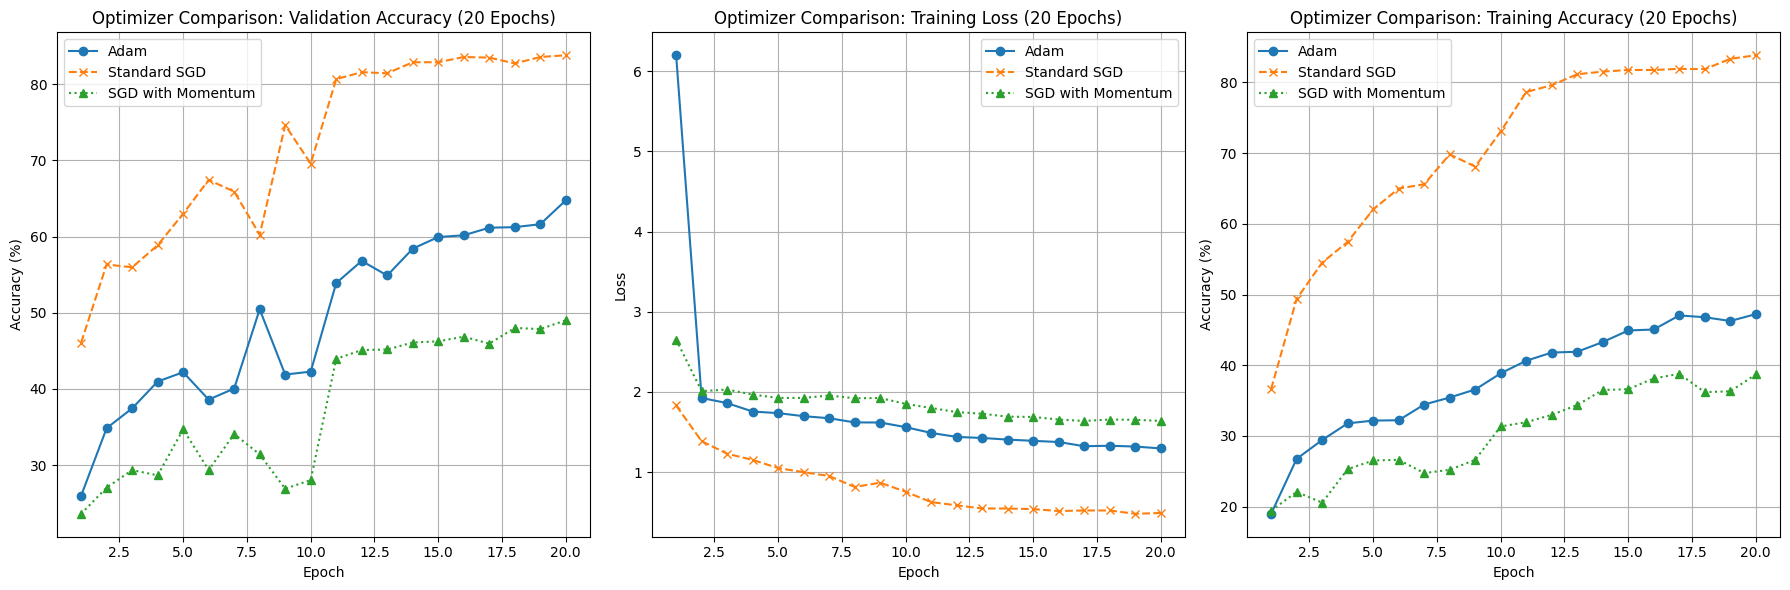


Optimizer Comparison plots generated.


In [17]:
# --- Plotting Comparison ---
plt.figure(figsize=(18, 6))

# Plot Validation Accuracy Comparison
plt.subplot(1, 3, 1)
plt.plot(range(1, NUM_EPOCHS_COMP + 1), adam_val_accuracies, marker='o', linestyle='-', label='Adam')
plt.plot(range(1, NUM_EPOCHS_COMP + 1), sgd_val_accuracies, marker='x', linestyle='--', label='Standard SGD')
plt.plot(range(1, NUM_EPOCHS_COMP + 1), sgd_momentum_val_accuracies, marker='^', linestyle=':', label='SGD with Momentum')
plt.title(f"Optimizer Comparison: Validation Accuracy ({NUM_EPOCHS_COMP} Epochs)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

# Plot Training Loss Comparison
plt.subplot(1, 3, 2)
plt.plot(range(1, NUM_EPOCHS_COMP + 1), adam_train_losses, marker='o', linestyle='-', label='Adam')
plt.plot(range(1, NUM_EPOCHS_COMP + 1), sgd_train_losses, marker='x', linestyle='--', label='Standard SGD')
plt.plot(range(1, NUM_EPOCHS_COMP + 1), sgd_momentum_train_losses, marker='^', linestyle=':', label='SGD with Momentum')
plt.title(f"Optimizer Comparison: Training Loss ({NUM_EPOCHS_COMP} Epochs)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Plot Training Accuracy Comparison
plt.subplot(1, 3, 3)
plt.plot(range(1, NUM_EPOCHS_COMP + 1), adam_train_accuracies, marker='o', linestyle='-', label='Adam')
plt.plot(range(1, NUM_EPOCHS_COMP + 1), sgd_train_accuracies, marker='x', linestyle='--', label='Standard SGD')
plt.plot(range(1, NUM_EPOCHS_COMP + 1), sgd_momentum_train_accuracies, marker='^', linestyle=':', label='SGD with Momentum')
plt.title(f"Optimizer Comparison: Training Accuracy ({NUM_EPOCHS_COMP} Epochs)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("\nOptimizer Comparison plots generated.")

In [18]:
# --- Evaluate on Test Set Function for Comparison Models ---
def evaluate_on_test_set_comp(model_instance, model_path, test_loader_comp, device_comp):
    model_instance.load_state_dict(torch.load(model_path)) # Load the best weights
    model_instance.to(device_comp)
    model_instance.eval() # Set to evaluation mode

    test_correct = 0
    test_total = 0

    with torch.no_grad():
        test_loop = tqdm(test_loader_comp, desc=f"Evaluating Test Set for model from {model_path}", leave=False)
        for images, labels in test_loop:
            images, labels = images.to(device_comp), labels.to(device_comp)
            outputs = model_instance(images)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_accuracy = 100 * test_correct / test_total
    return test_accuracy

print("\n--- Evaluating Comparison Models on Test Set ---")

adam_final_test_accuracy = evaluate_on_test_set_comp(model_adam_comp, adam_comp_model_path, test_loader, device)
print(f"Adam (Comparison) Final Test Accuracy: {adam_final_test_accuracy:.2f}%\n")

sgd_final_test_accuracy = evaluate_on_test_set_comp(model_sgd_comp, sgd_comp_model_path, test_loader, device)
print(f"Standard SGD (Comparison) Final Test Accuracy: {sgd_final_test_accuracy:.2f}%\n")

sgd_momentum_final_test_accuracy = evaluate_on_test_set_comp(model_sgd_momentum_comp, sgd_momentum_comp_model_path, test_loader, device)
print(f"SGD with Momentum (Comparison) Final Test Accuracy: {sgd_momentum_final_test_accuracy:.2f}%\n")

print("\n" + "="*50)
print("       Optimizer Performance Comparison Summary       ")
print("="*50 + "\n")
print(f"Final Test Accuracy for Adam: {adam_final_test_accuracy:.2f}%")
print(f"Final Test Accuracy for Standard SGD: {sgd_final_test_accuracy:.2f}%")
print(f"Final Test Accuracy for SGD with Momentum: {sgd_momentum_final_test_accuracy:.2f}%")
print("\nOptimizer Comparison Test Evaluation Complete.")


--- Evaluating Comparison Models on Test Set ---


Adam (Comparison) Final Test Accuracy: 63.44%



Standard SGD (Comparison) Final Test Accuracy: 84.59%



SGD with Momentum (Comparison) Final Test Accuracy: 47.73%


       Optimizer Performance Comparison Summary       

Final Test Accuracy for Adam: 63.44%
Final Test Accuracy for Standard SGD: 84.59%
Final Test Accuracy for SGD with Momentum: 47.73%

Optimizer Comparison Test Evaluation Complete.
